# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as pfunctions
import pyspark.sql.types as ptypes


from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Analysis") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
print("Rows: {} \nColumns: {}".format(df.count(), len(df.columns)))

Rows: 286500 
Columns: 18


In [6]:
# PySpark Null analysis reference https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
missing = df.select([pfunctions.count(pfunctions.when(pfunctions.isnull(c), c)).alias(c) for c in df.columns]).toPandas().T
missing.columns = ['null_count']
missing

,null_count
artist,58392
auth,0
firstName,8346
gender,8346
itemInSession,0
lastName,8346
length,58392
level,0
location,8346
method,0


In [7]:
# Check firstName missing values and corresponding userId matches
df.where(pfunctions.isnull(df.firstName)).select('userId').distinct().show()\

+------+
|userId|
+------+
|      |
+------+



In [8]:
# Only empty userId string values are present ("") check how many values for this are in userId
df.count() - df.filter(df.userId != "").count()

8346

In [9]:
# This matches the amount for firstName so drop all values of "" for userId as we can't tie in any user information
# as would be required by this project
df_clean = df.filter(df.userId != "")
df_clean.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [10]:
# Rest of missing information seems to be missing song information, but the information present would
# still be useful for modelling purposes

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [11]:
# Take out the first row for examination
df_clean.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [12]:
# Looking at the above output there are columns that jump out as not that useful
# Artist, Song, firstName, lastName, location, userAgent (due to it being potentially hard to split info from)

# Therefore I'm going to pull out some information from these columns to take a look
df_clean.select(['artist', 'song', 'firstName', 'lastName', 'location', 'userAgent']).limit(9).show(10)

+--------------------+--------------------+---------+--------+--------------------+--------------------+
|              artist|                song|firstName|lastName|            location|           userAgent|
+--------------------+--------------------+---------+--------+--------------------+--------------------+
|      Martha Tilston|           Rockpools|    Colin| Freeman|     Bakersfield, CA|Mozilla/5.0 (Wind...|
|    Five Iron Frenzy|              Canada|    Micah|    Long|Boston-Cambridge-...|"Mozilla/5.0 (Win...|
|        Adam Lambert|   Time For Miracles|    Colin| Freeman|     Bakersfield, CA|Mozilla/5.0 (Wind...|
|              Enigma|Knocking On Forbi...|    Micah|    Long|Boston-Cambridge-...|"Mozilla/5.0 (Win...|
|           Daft Punk|Harder Better Fas...|    Colin| Freeman|     Bakersfield, CA|Mozilla/5.0 (Wind...|
|The All-American ...|      Don't Leave Me|    Micah|    Long|Boston-Cambridge-...|"Mozilla/5.0 (Win...|
|The Velvet Underg...|         Run Run Run|    Micah|  

In [13]:
# Then exploration of the remaining columns

In [14]:
df_clean.select('auth').distinct().show() # Not very useful

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [15]:
df_clean.select('level').distinct().show() # Breakdown of level (free vs paid) could also be useful

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [16]:
df_clean.select('status').distinct().show() # Assuming this is error status codes, could also relate to churn

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [17]:
df_clean.select('method').distinct().show() # Assuming this is a HTTP request, can't imagine it being useful

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [18]:
df_clean.select('length').describe().show() # Similar to song info, can't imagine this is too useful

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [19]:
df_clean.select('itemInSession').describe().show() # Not very useful to know which item position an event is

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            278154|
|   mean|114.89918174824018|
| stddev|  129.851729399489|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [20]:
df_clean.select('registration').describe().show() # Timestamp of registration (assumably in unix format)

+-------+--------------------+
|summary|        registration|
+-------+--------------------+
|  count|              278154|
|   mean|1.535358834084427...|
| stddev| 3.291321616327586E9|
|    min|       1521380675000|
|    max|       1543247354000|
+-------+--------------------+



In [21]:
df_clean.select('ts').describe().show() # Timestamp of event (assumably in unix format)

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              278154|
|   mean|1.540958915431871...|
| stddev|1.5068287123306298E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



In [22]:
df_clean.select('sessionId').describe().show() # Unique ID of sessions

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



In [23]:
df_clean.select('page').distinct().sort('page').toPandas() # Looks like a very useful column

,page
0,About
1,Add Friend
2,Add to Playlist
3,Cancel
4,Cancellation Confirmation
5,Downgrade
6,Error
7,Help
8,Home
9,Logout


In [24]:
df_clean.groupby('page').count().sort('count', ascending=False).toPandas() # Could be quite useful, skewed though

,page,count
0,NextSong,228108
1,Thumbs Up,12551
2,Home,10082
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Logout,3226
7,Thumbs Down,2546
8,Downgrade,2055
9,Settings,1514


In [25]:
# Create a view to leverage SQL syntax going forward
df_clean.createOrReplaceTempView('logs')

In [26]:
spark.sql('SELECT COUNT(DISTINCT userId) AS dis_users FROM logs').show()

+---------+
|dis_users|
+---------+
|      225|
+---------+



In [27]:
# To split the dataset into test and training datasets (but keeping together user events) do the following

# Create a dataset with users that churned (1 represents churn)
churned = spark.sql('SELECT DISTINCT userId, 1 as churn FROM logs WHERE Page = "Cancellation Confirmation"')

# Then a datasets with users that didn't churn (0 represents no churn)
not_churned = spark.sql('SELECT DISTINCT userId, 0 as churn FROM logs \
                      WHERE userId NOT IN (SELECT DISTINCT userId FROM logs \
                      WHERE Page = "Cancellation Confirmation")')

# Union them together
churn_df = churned.union(not_churned)

# Create view to reference in SQL
churn_df.createOrReplaceTempView('churn')

# Add in random shuffling element to userIds
churn_df = spark.sql('SELECT * FROM churn ORDER BY RAND()')

# Recreate this view with the random shuffle
churn_df.createOrReplaceTempView('churn')

In [28]:
# visualize the distribution of users between churning or not
churn_pd_df = churn_df.toPandas()
churn_pd_df.groupby('churn', as_index = False).count()

,churn,userId
0,0,173
1,1,52


In [29]:
# Churn has been defined in our datasets, join it back into the overall dataset
# churn_pd_df.head()
full_churn_df = df_clean.join(churn_df, on = 'userId')

In [30]:
# Now to investigate some trends between churned and not churned values
full_churn_df.createOrReplaceTempView('churn_full')

In [31]:
# Comparison of the level of the accounts (free vs paid)
# full_churn_df.groupBy(['churn','level']).count().show()
spark.sql('SELECT churn, level, COUNT(level) AS count FROM churn_full GROUP BY 1, 2').show()

+-----+-----+------+
|churn|level| count|
+-----+-----+------+
|    0| free| 43333|
|    0| paid|189957|
|    1| paid| 32476|
|    1| free| 12388|
+-----+-----+------+



In [32]:
# Build a visualisation for the level amounts based on proportion
level_df = spark.sql('SELECT churn, level, COUNT(level) AS count FROM churn_full GROUP BY 1, 2').toPandas()

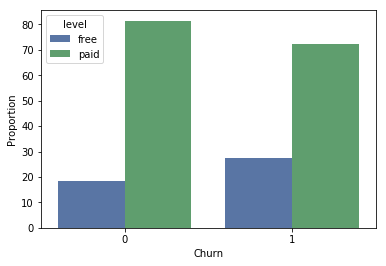

In [33]:
churn_sum_level = level_df.groupby('churn', as_index=False).sum()
level_df['proportion'] = (level_df.join(churn_sum_level, on = 'churn', lsuffix='_1')['count_1'] /
                          level_df.join(churn_sum_level, on = 'churn', lsuffix='_1')['count']) * 100

g = sns.barplot(x="churn", y="proportion", hue="level", data=level_df, palette="deep")
g.set(xlabel='Churn', ylabel="Proportion")
plt.show();

In [34]:
# Looks like there isn't much of a difference between free and paid accounts and churn

In [35]:
# Build a visualisation for the level amounts based on proportion
gender_df = spark.sql('SELECT churn, gender, COUNT(gender) AS count FROM churn_full GROUP BY 1, 2').toPandas()

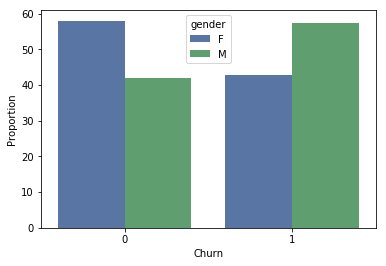

In [36]:
churn_sum_gender = level_df.groupby('churn', as_index=False).sum()
gender_df['proportion'] = (gender_df.join(churn_sum_gender, on = 'churn', lsuffix='_1')['count_1'] /
                          gender_df.join(churn_sum_gender, on = 'churn', lsuffix='_1')['count']) * 100

g = sns.barplot(x="churn", y="proportion", hue="gender", data=gender_df, palette="deep")
g.set(xlabel='Churn', ylabel="Proportion")
plt.show();

In [37]:
# Looks like there is a skew towards males churning from sparkify

In [38]:
# Taking into account timestamp of usage per user to get a profile of listening habits
# Use the factor 24 * 60 * 60 * 1000 to get songs and artists per day
listens_df = spark.sql("""
    SELECT
        userId,
        churn,
        COUNT(DISTINCT song)*24*60*60*1000 / (MAX(ts) - MIN(ts)) AS songs_per_day,
        COUNT(DISTINCT artist)*24*60*60*1000 / (MAX(ts) - MIN(ts)) AS artists_per_day
    FROM churn_full
    GROUP BY 1, 2
    """)

In [39]:
listens_df.groupBy('churn').avg('songs_per_day', 'artists_per_day').show()

+-----+------------------+--------------------+
|churn|avg(songs_per_day)|avg(artists_per_day)|
+-----+------------------+--------------------+
|    1|  72.0604862381857|   67.20742535555526|
|    0|  37.7352567773026|  33.228669029410725|
+-----+------------------+--------------------+



In [40]:
# Looks like churned users have a significantly higher listen amount than non churned users (Twice as much!)

In [41]:
# Deep diving into this by breaking down the user page daily usage amounts for churned vs not churned users

# First get the page counts per user
page_counts_df = spark.sql(
    """SELECT 
        userId,
        churn,
        page,
        COUNT(*) AS page_count
    FROM churn_full
    WHERE page IN ('Add Friend', 'Add to Playlist', 'Help', 'Login', 'Logout', 'NextSong', 'Roll Advert',
        'Settings','Thumbs Down', 'Thumbs Up')
    GROUP BY 1, 2, 3""")

# Get the days active per user
days_active_df = spark.sql(
    """SELECT 
        userId,
        (MAX(ts) - MIN(ts)) / (24 * 60 * 60 * 1000) AS days_active
    FROM churn_full
    GROUP BY userId""")

# Join these two dataframes together and get the active pages per day amount to describe user behaviour
page_activity_df = page_counts_df.join(days_active_df, "userId", "inner")
page_activity_df = page_activity_df.withColumn('pages_per_day', page_activity_df.page_count / page_activity_df.days_active)

# Aggregate this amount over the users by using a pivot
page_activity_agg_df = page_activity_df.groupBy('page').pivot('churn').avg('pages_per_day')

page_activity_agg_df = page_activity_agg_df.withColumnRenamed('0', 'not_churned')
page_activity_agg_df = page_activity_agg_df.withColumnRenamed('1', 'churned')

page_activity_agg_df.show()

+---------------+-------------------+------------------+
|           page|        not_churned|           churned|
+---------------+-------------------+------------------+
|    Thumbs Down|0.38293079179123285|1.9586845420537815|
|    Roll Advert|  2.322173563830428| 7.421197238752865|
|         Logout| 0.6232522709436888|0.9897750320170381|
|       Settings| 1.6359780188628494| 2.646798254413769|
|Add to Playlist| 1.1067587873838935| 2.934686315424889|
|     Add Friend| 0.6927238019914513|2.3511324917873107|
|       NextSong|  40.20637559224469| 74.53310132166251|
|      Thumbs Up| 1.9609748660000539| 4.880878647903342|
|           Help|0.26372036479048094|0.3270910329069824|
+---------------+-------------------+------------------+



In [42]:
# The above aggregation of user page activity reveals a lot of interesting information!
# 1.) It seems that general usage for people that churn is much higher than users that didn't churn
# 2.) There are about three times as many advert rolls for churned users than non-churned users, this could be one
#     of the reasons that users decided to churn in the first place
# 3.) Churned users thumbs up'd about 2.5 times as many songs as not churned users, but more interestingly users that
#     churned thumbs down'd songs over 5 times more than not churned users. Meaning that churned users more signifcantly
#     disliked the songs than not churned users. A stat that could have led to the churn in the first place (alongside 2)

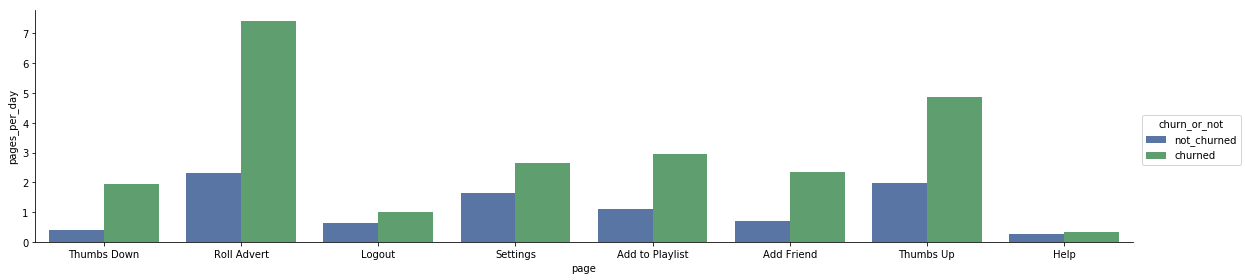

In [43]:
# A plot of the above would be a lot easier in helping visualise (and blog about :P) the above

# Put dataframe into Pandas dataframe and then melt for visualisation formatting
pd_df = page_activity_agg_df.toPandas()
usage_plot_df = pd.melt(pd_df, id_vars="page", var_name="churn_or_not", value_name="pages_per_day")

# Dropping 'NextSong' page as it was too large, and not useful to visualisation or analysis
usage_plot_df = usage_plot_df[usage_plot_df.page != 'NextSong']

# Present table in factorplot
sns.factorplot(x='page', y='pages_per_day', hue='churn_or_not', data=usage_plot_df, kind='bar',
               palette='deep', size=4, aspect=4)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [44]:
# To get the per user by churn page usage counts
page_usage = page_counts_df.groupBy('userId', 'churn').pivot('page',\
                            ['Add Friend','Add to Playlist','Help','Logout','NextSong','Roll Advert',\
                             'Settings','Thumbs Down','Thumbs Up']).sum('page_count')

# Fill non usages with 0
page_usage_filled = page_usage.fillna(0)

# Rename columns and make into DataFrame
user_page_usage_df = page_usage_filled.toDF('userId','churn','add_friend_page_usage','add_to_playlist_page_usage',\
                                               'help_page_usage','logout_page_usage','next_song_page_usage',\
                                               'roll_advert_page_usage','setting_page_usage','thumbs_down_page_usage',\
                                               'thumbs_up_page_usage')

In [45]:
# Checking to make sure the dataframe looks alright
user_page_usage_df.toPandas().iloc[1:5,:]

,userId,churn,add_friend_page_usage,add_to_playlist_page_usage,help_page_usage,logout_page_usage,next_song_page_usage,roll_advert_page_usage,setting_page_usage,thumbs_down_page_usage,thumbs_up_page_usage
1,200002,0,4,8,2,5,387,7,3,6,21
2,125,1,0,0,0,0,8,1,0,0,0
3,124,0,74,118,23,59,4079,4,20,41,171
4,51,1,28,52,12,24,2111,0,12,21,100


In [46]:
# To get the gender flag
gender_flag = spark.sql("""
    SELECT
        userId,
        churn,
        gender,
        IF(gender = 'M', 1, 0) AS gender_flag
    FROM churn_full
    GROUP BY 1, 2, 3""")

In [47]:
# Sanity checking the SQL results
gender_flag.toPandas().iloc[1:10,:]

,userId,churn,gender,gender_flag
1,200002,0,M,1
2,125,1,M,1
3,124,0,F,0
4,51,1,M,1
5,7,0,M,1
6,15,0,M,1
7,54,1,F,0
8,155,0,F,0
9,100014,1,M,1


In [48]:
# Joining together the dataframes to get the modelling dataset
# listens_df = songs_artists_df
# #  = user_sessions_duration_df
# user_page_usage_df = user_page_rate_df
# gender_flag = user_genderFlag_df

modelling_dataset_df = listens_df.join(user_page_usage_df.drop('churn'), "userId", "inner")\
    .join(gender_flag.drop('churn').drop('gender'), "userId", "inner")

In [49]:
# Sanity checking the modelling dataset
modelling_dataset_df.toPandas().iloc[1:5,:]

,userId,churn,songs_per_day,artists_per_day,add_friend_page_usage,add_to_playlist_page_usage,help_page_usage,logout_page_usage,next_song_page_usage,roll_advert_page_usage,setting_page_usage,thumbs_down_page_usage,thumbs_up_page_usage,gender_flag
1,200002,0,8.308276,7.451073,4,8,2,5,387,7,3,6,21,1
2,125,1,389.627959,389.627959,0,0,0,0,8,1,0,0,0,1
3,124,0,55.652834,37.201895,74,118,23,59,4079,4,20,41,171,0
4,51,1,117.494976,87.772676,28,52,12,24,2111,0,12,21,100,1


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [50]:
# Drop the userId column and get feature column names for Vector Assembler
modelling_df = modelling_dataset_df.drop('userId')
features_col_names = modelling_df.columns
features_col_names.remove('churn')

In [51]:
assembler = VectorAssembler().setInputCols(features_col_names).setOutputCol("features")
modelling_assember = assembler.transform(modelling_df)

train_df, test_df = modelling_assember.randomSplit([0.80, 0.20], seed=47)

In [52]:
def evaluate_model(model_type, model, data):
    
    '''
    Input:
        model_type - model type that was trained
        model - the trained model
        data - data to test model validation metrics against
    
    Output:
        results - results of f1, recall, precision and accuracy testing metrics against model
    '''

    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn", metricName="f1")
    evaluator.setMetricName("f1")
    
    predictions = model.transform(data)

    results = {}
    results["model"] = model_type
    results["f1"] = evaluator.evaluate(predictions, {evaluator.metricName:"f1"})
    results["precision"] = evaluator.evaluate(predictions, {evaluator.metricName:"weightedPrecision"})
    results["recall"] = evaluator.evaluate(predictions, {evaluator.metricName:"weightedRecall"})
    results["accuracy"] = evaluator.evaluate(predictions, {evaluator.metricName:"accuracy"})

    return results

In [53]:
def execute_model(model_type, train, test):
    '''
    Input:
        model_type - specify model type to train
        train - training data for model
        test - testing data for model testing metrics (f1, recall, precision, accuracy)
        
    Output:
        results
    '''
    
    pipeline_stages = []
    
    scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
    pipeline_stages += [scaler]
 
    evaltr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn", metricName="f1")

    if model_type == "LR":
        classifier = LogisticRegression(featuresCol = "features", labelCol = "churn")

        param_grid = ParamGridBuilder().addGrid(classifier.maxIter, [50, 100, 150]) \
            .addGrid(classifier.threshold, [0.4, 0.5, 0.6]) \
            .build()
    
    elif model_type == "RF":
        classifier = RandomForestClassifier(featuresCol = "features", labelCol = "churn",
                                            featureSubsetStrategy="auto", impurity='gini')

        param_grid = ParamGridBuilder().addGrid(classifier.numTrees, [3, 4, 5]) \
            .addGrid(classifier.maxDepth, [5, 10, 20]) \
            .build()
    
    elif model_type == "GB":
        classifier = GBTClassifier(featuresCol = "features", labelCol = "churn")

        param_grid = ParamGridBuilder().addGrid(classifier.maxIter, [10, 20, 30]) \
            .addGrid(classifier.maxDepth, [5, 10, 20]) \
            .build()
 
    cv = CrossValidator(estimator = classifier, estimatorParamMaps = param_grid, evaluator = evaltr, numFolds = 5)

    pipeline_stages.append(classifier)    
    pipeline = Pipeline(stages = pipeline_stages)
    model = pipeline.fit(train)
    
    return model, evaluate_model(model_type, model, test)

In [54]:
lr_model, logistic_regression_results = execute_model('LR', train_df, test_df)
logistic_regression_results

{'model': 'LR',
 'f1': 0.7272633744855966,
 'precision': 0.7277462121212122,
 'recall': 0.7708333333333333,
 'accuracy': 0.7708333333333334}

In [55]:
rf_model, random_forest_results = execute_model('RF', train_df, test_df)
random_forest_results

{'model': 'RF',
 'f1': 0.8190883190883191,
 'precision': 0.8217189314750291,
 'recall': 0.8333333333333333,
 'accuracy': 0.8333333333333334}

In [56]:
gb_model, gradient_boosted_tree_results = execute_model('GB', train_df, test_df)
gradient_boosted_tree_results

{'model': 'GB',
 'f1': 0.7742455826881081,
 'precision': 0.7783564814814816,
 'recall': 0.7708333333333334,
 'accuracy': 0.7708333333333334}

In [57]:
results_df = spark.read.json(spark.sparkContext
    .parallelize([logistic_regression_results, random_forest_results, gradient_boosted_tree_results])) \
    .select("model", "f1", "precision", "recall", "accuracy") \
    .show()

+-----+------------------+------------------+------------------+------------------+
|model|                f1|         precision|            recall|          accuracy|
+-----+------------------+------------------+------------------+------------------+
|   LR|0.7272633744855966|0.7277462121212122|0.7708333333333333|0.7708333333333334|
|   RF|0.8190883190883191|0.8217189314750291|0.8333333333333333|0.8333333333333334|
|   GB|0.7742455826881081|0.7783564814814816|0.7708333333333334|0.7708333333333334|
+-----+------------------+------------------+------------------+------------------+



In [58]:
# Random Forest had best F1 score and Accuracy results

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.